# Proyecto Final

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

## Importación de datos

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import numpy as np
import re

### Descripción de los datos

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente. La información del contrato es válida a partir del 1 de febrero de 2020.

In [3]:
## Importamos los datasets
contract = pd.read_csv('datasets/contract.csv')
personal = pd.read_csv('datasets/personal.csv')
internet = pd.read_csv('datasets/internet.csv')
phone = pd.read_csv('datasets/phone.csv')

## Preprocesamiento de los datos

**Contract**

In [4]:
contract.info()
print("\n" + "="*50 + "\n")
print(contract.describe())
print("\n" + "="*50 + "\n")
print(contract.isnull().sum())
print("\n" + "="*50 + "\n")
print(contract[contract.duplicated].sum())
print("\n" + "="*50 + "\n")
display(contract.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges  

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
3261,2378-YIZKA,2014-06-01,No,Two year,Yes,Credit card (automatic),85.00,5607.75
681,7501-IWUNG,2015-01-01,No,Two year,Yes,Bank transfer (automatic),73.80,4616.05
1079,0455-XFASS,2019-11-01,No,Month-to-month,Yes,Electronic check,69.55,200.2
5585,4667-OHGKG,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,19.30,19.3
3387,3530-CRZSB,2019-07-01,No,Month-to-month,No,Mailed check,20.65,155.9


Convertimos los nombres de las columnas a snake_case para estandarizar el formato.

In [5]:
# Función para convertir nombres de columnas a snake_case, incluyendo customerID a customer_id
def to_snake_case(col_name):
    # Convertir customerID a customer_id específicamente
    if col_name == 'customerID':
        return 'customer_id'
    # Convertir a snake_case el resto de columnas
    snake_case_col = '_'.join(re.findall(r'[A-Z][a-z0-9]*', col_name)).lower()
    return snake_case_col

# Convertir nombres de columnas a snake_case
snake_case_cols = [to_snake_case(col) for col in contract.columns]
contract.columns = snake_case_cols

# Verificar los nombres de las columnas después de la conversión
print('Nombres de columnas normalizados:')
print(contract.columns)

Nombres de columnas normalizados:
Index(['customer_id', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')


Convertimos la columna `'begin_date'` a tipo `datetime`

In [6]:
# Convertir la columna 'begin_date' a tipo datetime
contract['begin_date'] = pd.to_datetime(contract['begin_date'], errors='coerce')
# Verificar si la conversión fue exitosa
print(contract['begin_date'].dtype)  # Debería mostrar 'datetime64[ns]'
print(contract['begin_date'].head())  # Ver los primeros valores de la columna

datetime64[ns]
0   2020-01-01
1   2017-04-01
2   2019-10-01
3   2016-05-01
4   2019-09-01
Name: begin_date, dtype: datetime64[ns]


Ademas se obeserva que el tipo de datos de las columna `'total_charges'` es `object` y debería ser `float` al igual que la columna `'monthly_charges'` así que vamos a cambiarla. Pero antes se va a revisar si hay datos que no sean números, como por ejemplo buscar si hay filas que tienen solamente un espacio en blanco

También se van a buscar si hay filas repetidas.

In [7]:
# Buscamos si hay strings en nuestra columna de 'TotalCharges'
print(contract[contract['total_charges'] == ' ']['total_charges'].count())

11


`'total_charges'` debería contener solo valores numéricos (como cantidades facturadas). Encontrar espacios en esta columna significa que esos registros tienen datos faltantes o incorrectos.

In [8]:
# Reemplazar espacios en blanco en 'total_charges' con NaN
contract['total_charges'] = contract['total_charges'].replace(' ', pd.NA)

# Convertir la columna 'total_charges' a tipo float
contract['total_charges'] = pd.to_numeric(contract['total_charges'], errors='coerce')

# Verificar si la conversión fue exitosa
print(contract['total_charges'].dtype)  # Debería mostrar 'float64'
print(contract['total_charges'].head())  # Ver los primeros valores de la columna

float64
0      29.85
1    1889.50
2     108.15
3    1840.75
4     151.65
Name: total_charges, dtype: float64


In [9]:
# Calcular el promedio de 'total_charges', omitiendo los valores nulos
average_total_charges = contract['total_charges'].mean()

# Rellenar los valores nulos con el promedio
contract['total_charges'].fillna(average_total_charges, inplace=True)

# Verificar si hay valores nulos restantes
print(contract['total_charges'].isnull().sum())

0


C:\Users\jpizz\AppData\Local\Temp\ipykernel_6888\1974059395.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  contract['total_charges'].fillna(average_total_charges, inplace=True)


Ahora los valores de la columna `'total_charges'` han sido corregidos: los espacios vacíos han sido reemplazados con `NaN`, y estos valores nulos fueron rellenados utilizando el promedio de la columna. La conversión a tipo `float` también se realizó con éxito, y al verificar nuevamente, se confirmó que no quedan valores nulos en la columna, lo que nos permite continuar con el análisis sin problemas relacionados con datos faltantes o inconsistentes en esta variable.

**Personal**

In [10]:
personal.info()
print("\n" + "="*50 + "\n")
print(personal.describe())
print("\n" + "="*50 + "\n")
print(personal.isnull().sum())
print("\n" + "="*50 + "\n")
print(personal[personal.duplicated].sum())
print("\n" + "="*50 + "\n")
display(personal.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: object




,customerID,gender,SeniorCitizen,Partner,Dependents
4577,0471-ARVMX,Female,1,Yes,No
4195,1768-HNVGJ,Female,1,No,No
6484,2911-IJORQ,Male,0,No,No
1268,2408-TZMJL,Male,0,Yes,No
232,8937-RDTHP,Male,0,No,No


In [11]:
# Función para convertir nombres de columnas a snake_case, incluyendo customerID a customer_id
def to_snake_case(col_name):
    # Convertir customerID a customer_id específicamente
    if col_name == 'customerID':
        return 'customer_id'
    # Convertir el resto de las columnas a snake_case
    # La expresión regular ahora captura los casos de nombres con letras mayúsculas y minúsculas
    if not col_name:
        return col_name
    snake_case_col = '_'.join(re.findall(r'[a-zA-Z][a-z]*', col_name)).lower()
    return snake_case_col

# Convertir los nombres de las columnas a snake_case
snake_case_cols = [to_snake_case(col) for col in personal.columns]
personal.columns = snake_case_cols

# Verificar los nombres de las columnas después de la conversión
print('Nombres de columnas normalizados:')
print(personal.columns)

Nombres de columnas normalizados:
Index(['customer_id', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')


Todo está en orden para seguir trabajando

**Internet**

In [12]:
internet.info()
print("\n" + "="*50 + "\n")
print(internet.describe())
print("\n" + "="*50 + "\n")
print(internet.isnull().sum())
print("\n" + "="*50 + "\n")
print(internet[internet.duplicated].sum())
print("\n" + "="*50 + "\n")
display(internet.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     3186-AJIEK     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMo

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
238,6556-DBKZF,Fiber optic,No,No,Yes,No,No,No
4205,8065-YKXKD,Fiber optic,No,No,No,No,No,No
1034,5027-XWQHA,DSL,No,No,No,No,No,No
5465,6633-SYEUS,Fiber optic,No,Yes,Yes,Yes,No,No
519,0195-IESCP,Fiber optic,No,No,No,No,No,Yes


In [13]:
# Función para convertir nombres de columnas a snake_case
def to_snake_case(col_name):
    # Convertir customerID a customer_id específicamente
    if col_name == 'customerID':
        return 'customer_id'
    
    # Condición especial para 'StreamingTV'
    if col_name == 'StreamingTV':
        return 'streaming_tv'
    
    # Convertir a snake_case el resto de columnas
    # Reemplazar mayúsculas por minúsculas con guiones bajos
    col_name = re.sub(r'(?<!^)(?=[A-Z])', '_', col_name).lower()
    
    # Reemplazar caracteres no alfanuméricos por guiones bajos
    col_name = re.sub(r'[^a-z0-9_]', '_', col_name)
    
    # Asegurarse de que no haya guiones bajos duplicados
    col_name = re.sub(r'_+', '_', col_name)
    
    # Retornar el nombre convertido a snake_case
    return col_name

# Convertir los nombres de las columnas a snake_case
snake_case_cols = [to_snake_case(col) for col in internet.columns]
internet.columns = snake_case_cols

# Verificar los nombres de las columnas después de la conversión
print('Nombres de columnas normalizados:')
print(internet.columns)

Nombres de columnas normalizados:
Index(['customer_id', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies'],
      dtype='object')


Todo está en orden para seguir trabajando

**Phone**

In [14]:
phone.info()
print("\n" + "="*50 + "\n")
print(phone.describe())
print("\n" + "="*50 + "\n")
print(phone.isnull().sum())
print("\n" + "="*50 + "\n")
print(phone[phone.duplicated].sum())
print("\n" + "="*50 + "\n")
display(phone.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


        customerID MultipleLines
count         6361          6361
unique        6361             2
top     3186-AJIEK            No
freq             1          3390


customerID       0
MultipleLines    0
dtype: int64


customerID       0
MultipleLines    0
dtype: object




,customerID,MultipleLines
2156,5067-WJEUN,No
5110,9801-GDWGV,Yes
6197,9700-ZCLOT,No
5153,5229-PRWKT,Yes
2695,2674-MIAHT,Yes


In [15]:
# Función para convertir nombres de columnas a snake_case, incluyendo customerID a customer_id
def to_snake_case(col_name):
    # Convertir customerID a customer_id específicamente
    if col_name == 'customerID':
        return 'customer_id'
    # Convertir a snake_case el resto de columnas
    snake_case_col = '_'.join(re.findall(r'[A-Z][a-z0-9]*', col_name)).lower()
    return snake_case_col

# Convertir nombres de columnas a snake_case
snake_case_cols = [to_snake_case(col) for col in phone.columns]
phone.columns = snake_case_cols

# Verificar los nombres de las columnas después de la conversión
print('Nombres de columnas normalizados:')
print(phone.columns)

Nombres de columnas normalizados:
Index(['customer_id', 'multiple_lines'], dtype='object')


Todo está en orden para seguir trabajando

## EDA

### Unión de Datasets

Antes de seguir voy a unir los datasets ya que se podrá tener una vista integral de cada cliente y hacer un análisis más completo y robusto.

In [16]:
# Unir datasets
merged_df = pd.merge(contract, personal, how='left', on='customer_id')
merged_df = pd.merge(merged_df, internet, how='left', on='customer_id')
merged_df = pd.merge(merged_df, phone, how='left', on='customer_id')

# Verificar la unión
print(merged_df.info())
print(merged_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  online_security    5517 non-null   object        
 14  online_b

In [17]:
#Verificación de valores nulos
print(merged_df.isnull().sum())

customer_id             0
begin_date              0
end_date                0
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
multiple_lines        682
dtype: int64


In [18]:
#Limpieza de datos
merged_df.fillna('None', inplace=True)

In [19]:
# Contar duplicados
print(merged_df.duplicated().sum())

0


Creamos una nueva columna llamada `'contract_ended'` que nos muestra que cliente sigue con contrato activo y quien no

In [20]:
# Crear una nueva columna 'contract_ended' que muestra 1 si el contrato terminó y 0 si no terminó
merged_df['contract_ended'] = merged_df['end_date'].apply(lambda x: 1 if x != 'No' else 0)

# Verificar los primeros registros para confirmar la creación de la nueva columna
print(merged_df[['customer_id', 'end_date', 'contract_ended']].head())

  customer_id             end_date  contract_ended
0  7590-VHVEG                   No               0
1  5575-GNVDE                   No               0
2  3668-QPYBK  2019-12-01 00:00:00               1
3  7795-CFOCW                   No               0
4  9237-HQITU  2019-11-01 00:00:00               1


### Cual es la cantidad de clientes con contrato activo y terminado?

C:\Users\jpizz\AppData\Local\Temp\ipykernel_6888\428232471.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=contract_status_counts.index, y=contract_status_counts.values, palette='Set2')


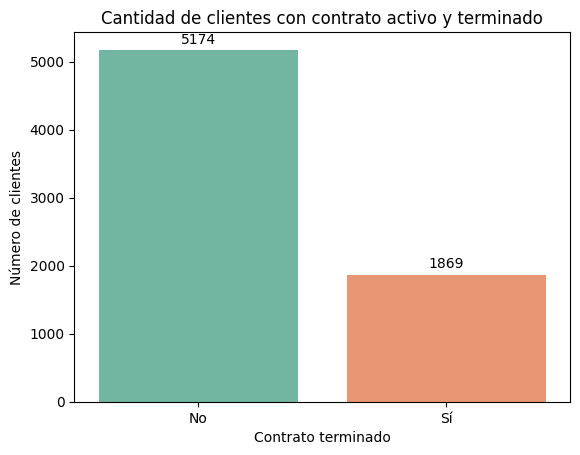

In [21]:
# Contar el número de clientes que han terminado o no su contrato
contract_status_counts = merged_df['contract_ended'].value_counts()

# Crear el gráfico de barras
sns.barplot(x=contract_status_counts.index, y=contract_status_counts.values, palette='Set2')

# Título y etiquetas del gráfico
plt.title('Cantidad de clientes con contrato activo y terminado')
plt.ylabel('Número de clientes')
plt.xlabel('Contrato terminado')

# Etiquetas personalizadas para el eje x (0 para No, 1 para Sí)
plt.xticks(ticks=[0, 1], labels=['No', 'Sí'])

# Añadir los números encima de las barras
for i, count in enumerate(contract_status_counts.values):
    plt.text(i, count + 50, str(count), ha='center', va='bottom', fontsize=10)  

# Mostrar el gráfico
plt.show()

- Aunque la mayoría de los clientes siguen con contratos activos, una cantidad notable ha terminado su contrato. Esto podría sugerir una tasa de cancelación significativa, lo que debería ser un punto de atención para la empresa.
- Sería beneficioso investigar más a fondo las razones por las cuales los clientes están cancelando sus contratos para diseñar estrategias de retención más efectivas y reducir el número de cancelaciones.

### ¿Cuál es la distribución de los tipos de contratos entre los clientes?

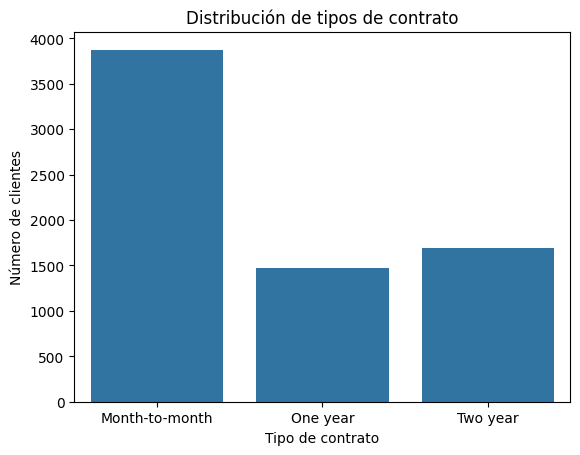

In [22]:
sns.countplot(x='type', data=merged_df)
plt.title('Distribución de tipos de contrato')
plt.xlabel('Tipo de contrato')
plt.ylabel('Número de clientes')
plt.show()

- El gráfico muestra que la mayoría de los clientes de la empresa tienen contratos de mes a mes (Month-to-month), mientras que una menor cantidad de clientes opta por contratos de un año o dos años.

- Este es el tipo de contrato más común, con alrededor de 4,000 clientes. Los contratos mensuales tienden a ser más flexibles, lo que podría explicar la alta preferencia por este tipo de contrato.
- Dado que la mayoría de los clientes tienen contratos de corto plazo (mes a mes), la empresa podría enfocarse en estrategias de retención para este segmento, ya que es más probable que cancelen debido a la flexibilidad de estos contratos.

### ¿Cuál es la tasa de cancelación en función del tipo de contrato?

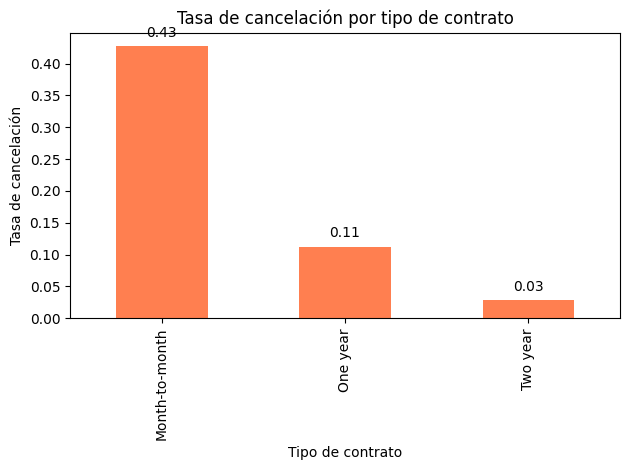

In [23]:
# Calcular la tasa de cancelación por tipo de contrato
churn_rate = merged_df.groupby('type')['end_date'].apply(lambda x: (x != 'No').mean())

# Crear el gráfico de barras
ax = churn_rate.plot(kind='bar', color='coral')

# Título y etiquetas
plt.title('Tasa de cancelación por tipo de contrato')
plt.ylabel('Tasa de cancelación')
plt.xlabel('Tipo de contrato')

# Añadir etiquetas encima de cada barra
for i, value in enumerate(churn_rate):
    ax.text(i, value + 0.01, f'{value:.2f}', ha='center', va='bottom')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


- Contratos a largo plazo (uno o dos años) son significativamente menos propensos a cancelaciones, mientras que los contratos mensuales tienen una alta probabilidad de ser cancelados.
- Esto sugiere que la empresa podría beneficiarse de fomentar la conversión de clientes de contratos mes a mes hacia contratos a más largo plazo mediante promociones o incentivos para reducir la tasa de cancelación.

### ¿Cuál es la relación entre las tarifas mensuales y la tasa de cancelación?

C:\Users\jpizz\AppData\Local\Temp\ipykernel_6888\2034213694.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='contract_ended', y='monthly_charges', data=merged_df, palette=colors)


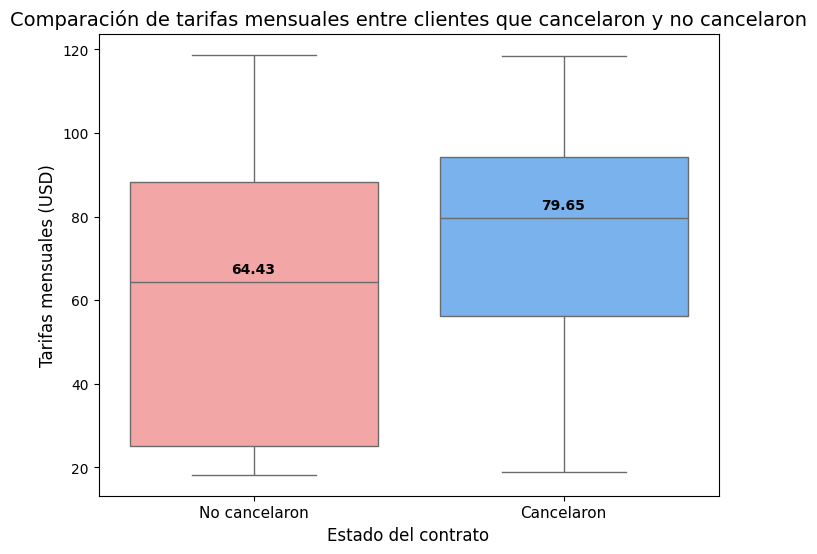

In [24]:
# Definir colores para cancelar y no cancelar
colors = ['#FF9999', '#66B2FF']

# Crear el boxplot con las mejoras
plt.figure(figsize=(8, 6))
sns.boxplot(x='contract_ended', y='monthly_charges', data=merged_df, palette=colors)

# Etiquetas y títulos más claros
plt.title('Comparación de tarifas mensuales entre clientes que cancelaron y no cancelaron', fontsize=14)
plt.xlabel('Estado del contrato', fontsize=12)
plt.ylabel('Tarifas mensuales (USD)', fontsize=12)

# Personalizar etiquetas del eje X para claridad
plt.xticks(ticks=[0, 1], labels=['No cancelaron', 'Cancelaron'], fontsize=11)

# Mostrar la mediana en el gráfico
medians = merged_df.groupby('contract_ended')['monthly_charges'].median()
for index, median in enumerate(medians):
    plt.text(index, median + 2, f'{median:.2f}', horizontalalignment='center', color='black', weight='semibold')

plt.show()



- No parece haber una gran diferencia en las tarifas entre quienes cancelan y quienes no, pero existe una tendencia leve a que los clientes que cancelaron paguen tarifas ligeramente más altas.
- Es posible que algunos clientes cancelen porque perciben las tarifas como demasiado altas en relación con el servicio, pero no es una causa determinante según el gráfico. Una análisis más detallado podría explorar si hay otros factores que combinados con las tarifas (como la satisfacción o el uso del servicio) influyen en la cancelación.

### ¿Cuál es la distribución del tiempo que los clientes han estado con la empresa? ¿Hay alguna diferencia entre los que cancelaron y los que no?

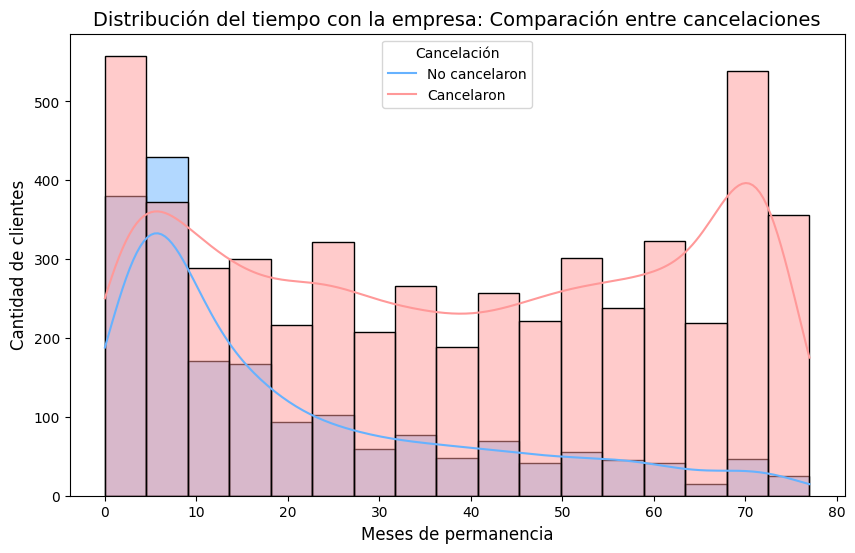

In [25]:
# Crear la columna 'tenure'
merged_df['tenure'] = (pd.to_datetime('2020-02-01') - pd.to_datetime(merged_df['begin_date'])).dt.days // 30

# Graficar la distribución de tenure, diferenciando entre clientes que cancelaron y no
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_df, x='tenure', hue='contract_ended', kde=True, palette=['#FF9999', '#66B2FF'])

# Etiquetas y título del gráfico
plt.title('Distribución del tiempo con la empresa: Comparación entre cancelaciones', fontsize=14)
plt.xlabel('Meses de permanencia', fontsize=12)
plt.ylabel('Cantidad de clientes', fontsize=12)
plt.legend(title='Cancelación', labels=['No cancelaron', 'Cancelaron'])
plt.show()

- Cancelaciones tempranas: El gráfico sugiere que hay un riesgo elevado de cancelación en los primeros meses de servicio, especialmente dentro del primer año.
- Lealtad a largo plazo: Aquellos que pasan el primer año tienden a quedarse mucho más tiempo, especialmente alrededor de los 50 a 70 meses.

### ¿Ciertos métodos de pago están más relacionados con la cancelación que otros?

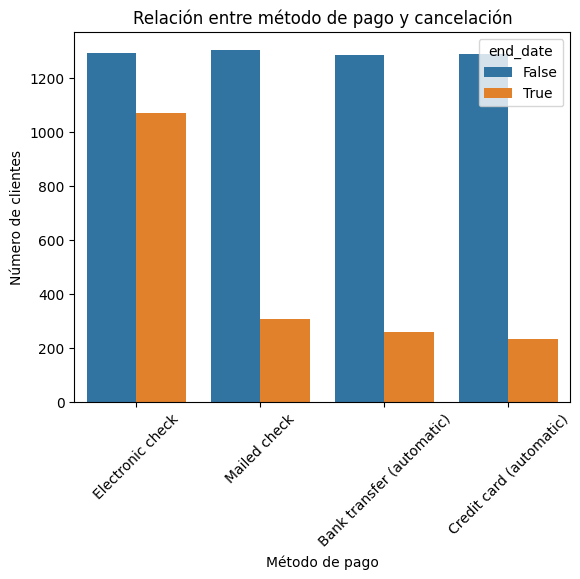

In [26]:
sns.countplot(x='payment_method', hue=merged_df['end_date'] != 'No', data=merged_df)
plt.title('Relación entre método de pago y cancelación')
plt.xlabel('Método de pago')
plt.ylabel('Número de clientes')
plt.xticks(rotation=45)
plt.show()

- Los cheques electrónicos están fuertemente relacionados con cancelaciones de contratos. Esto podría indicar una fricción o insatisfacción entre los clientes que usan este método de pago.
- Por otro lado, los métodos de pago automáticos como la transferencia bancaria y la tarjeta de crédito están asociados con una menor tasa de cancelación, lo que sugiere que los clientes que utilizan estos métodos tienden a ser más leales.

## Modelos

Dado que ya tenemos las columna `contract_ended` es seguro eliminar las columnas originales de fechas (begin_date y end_date), ya que esas columnas ya han sido transformadas en características más útiles para el modelo.

In [28]:
# Eliminación de columnas
merged_df = merged_df.drop(['customer_id', 'begin_date', 'end_date'], axis=1)

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               7043 non-null   object 
 1   paperless_billing  7043 non-null   object 
 2   payment_method     7043 non-null   object 
 3   monthly_charges    7043 non-null   float64
 4   total_charges      7043 non-null   float64
 5   gender             7043 non-null   object 
 6   senior_citizen     7043 non-null   int64  
 7   partner            7043 non-null   object 
 8   dependents         7043 non-null   object 
 9   internet_service   7043 non-null   object 
 10  online_security    7043 non-null   object 
 11  online_backup      7043 non-null   object 
 12  device_protection  7043 non-null   object 
 13  tech_support       7043 non-null   object 
 14  streaming_tv       7043 non-null   object 
 15  streaming_movies   7043 non-null   object 
 16  multiple_lines     7043 

Se van a transformar todas las columnas que contienen `'Yes'` y `'No'` a valores numéricos 1 y 0 respectivamente, para evitar que al aplicar la codificación OHE se generen columnas adicionales. Se ha implementado una función para realizar esta tarea. En cuanto a los valores `'None'`, que aparecieron como resultado de la fusión de los cuatro datasets, estos serán reemplazados por el valor más frecuente (moda) de cada columna correspondiente, asegurando que no queden valores faltantes.

In [29]:
# Función para transformar 'Yes' y 'No' a 1 y 0, y reemplazar 'None' con la moda
def transformar_yes_no(df, columnas):
    # Iterar sobre las columnas proporcionadas
    for columna in columnas:
        # Si 'None' está presente, reemplazarlo por la moda de la columna
        if 'None' in df[columna].values:
            valor_moda = df[columna].mode()[0]
            df[columna] = df[columna].replace('None', valor_moda)

        # Mapear 'Yes' a 1 y 'No' a 0
        df[columna] = df[columna].apply(lambda x: 1 if x == 'Yes' else 0)

        # Convertir la columna a tipo entero
        df[columna] = df[columna].astype(int)
    
    return df

In [30]:
# Lista de columnas a transformar
columnas_binarias = ['paperless_billing', 'partner', 'dependents', 'multiple_lines', 'online_security',
                     'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

# Aplicar la transformación al DataFrame
merged_df = transformar_yes_no(merged_df, columnas_binarias)

In [31]:
display(merged_df.sample(3))

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,contract_ended,tenure
568,Month-to-month,1,Electronic check,100.25,3527.60,Female,0,0,0,Fiber optic,0,0,1,0,1,1,1,1,38
2541,Two year,1,Credit card (automatic),53.80,3952.45,Female,0,1,1,DSL,1,0,1,0,1,1,0,0,73
5206,Two year,0,Bank transfer (automatic),65.60,2313.80,Male,0,0,0,DSL,1,1,1,1,0,0,0,0,37


### OHE

In [32]:
# Aplicar One-Hot Encoding (OHE) a las columnas restantes
merged_ohe_df = pd.get_dummies(merged_df, drop_first=True)

# Verificar el resultado de la codificación OHE
print(f"Dimensiones después de la codificación OHE: {merged_ohe_df.shape}")
display(merged_ohe_df.sample(5))

Dimensiones después de la codificación OHE: (7043, 23)


,paperless_billing,monthly_charges,total_charges,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,...,contract_ended,tenure,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,internet_service_Fiber optic,internet_service_None
1402,1,35.00,553.00,0,0,1,0,0,0,0,...,1,19,False,False,False,True,False,False,False,False
4525,1,93.40,2979.30,0,0,0,1,1,1,0,...,0,32,False,False,True,False,False,True,True,False
6897,1,80.40,4981.15,0,0,0,0,1,1,1,...,0,62,False,False,False,False,False,True,False,False
5246,1,79.75,164.50,0,0,0,0,0,0,0,...,1,4,False,False,False,True,False,False,True,False
63,1,54.40,957.10,0,1,1,0,0,1,1,...,0,18,True,False,True,False,False,False,False,False


### Segmentación de los Datos

In [33]:
# Función para separar características (features) y objetivo (target)
def features_target(data, target_column):
    features = data.drop(target_column, axis=1)
    target = data[target_column]
    return features, target

In [34]:
# Función para dividir los datos en entrenamiento y validación
def train_valid(features, target, test_size=0.2):
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=test_size, random_state=12345, stratify=target)
    return features_train, features_valid, target_train, target_valid

In [35]:
# Usar el DataFrame codificado (merge_ohe_df) y la columna 'contract_ended'
features, target = features_target(merged_ohe_df, 'contract_ended')


In [36]:
# Dividir en conjuntos de entrenamiento y validación
features_train, features_valid, target_train, target_valid = train_valid(features, target)


### Escalar características numéricas

In [37]:
# Función para escalar características numéricas
def features_scaler(features_train, features_valid, numeric_columns):
    scaler = StandardScaler()
    scaler.fit(features_train[numeric_columns])
    
    # Crear copias para evitar advertencias de pandas
    features_train_scaled = features_train.copy()
    features_valid_scaled = features_valid.copy()
    
    # Escalar las características numéricas
    features_train_scaled[numeric_columns] = scaler.transform(features_train[numeric_columns])
    features_valid_scaled[numeric_columns] = scaler.transform(features_valid[numeric_columns])
    
    return features_train_scaled, features_valid_scaled

In [38]:
# Escalar las características numéricas
numeric_columns = ['tenure', 'monthly_charges', 'total_charges']  # Ajusta según tu dataset
features_train_scaled, features_valid_scaled = features_scaler(features_train, features_valid, numeric_columns)

### Sobremuestreo y Submuestreo

In [39]:
def resample_data(features, target, method='upsample', repeat=3, fraction=0.2):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    if method == 'upsample':
        resampled_features = pd.concat([features_zeros] + [features_ones] * repeat)
        resampled_target = pd.concat([target_zeros] + [target_ones] * repeat)
    elif method == 'downsample':
        resampled_features = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
        resampled_target = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    return shuffle(resampled_features, resampled_target, random_state=12345)


In [40]:
# Aplicar sobremuestreo (upsampling) en el conjunto de entrenamiento
features_train_up, target_train_up = resample_data(features_train_scaled, target_train, method='upsample', repeat=3)

### Entrenar y evaluar modelos

In [41]:
# Función para entrenar y evaluar el modelo con ROC y AUC
def eval_model(model, features_train, target_train, features_valid, target_valid):
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    predictions_valid_prob = model.predict_proba(features_valid)[:, 1]
    
    auc_roc = roc_auc_score(target_valid, predictions_valid_prob)
    accuracy = accuracy_score(target_valid, predictions_valid)
    f1 = f1_score(target_valid, predictions_valid)
    
    print(f'\nModelo: {model.__class__.__name__}')
    print('Matriz de confusión:\n', confusion_matrix(target_valid, predictions_valid))
    print(f'AUC-ROC: {auc_roc:.4f}')
    print(f'Exactitud: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    # Graficar la curva ROC
    fpr, tpr, _ = roc_curve(target_valid, predictions_valid_prob)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc_roc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.show()
    
    return auc_roc, accuracy, f1


In [42]:
# Función para seleccionar los mejores modelos
def grid_model(grid_search, features_train, target_train):
    grid_search.fit(features_train, target_train)
    best_model = grid_search.best_estimator_
    best_param = grid_search.best_params_
    return best_model, best_param

In [45]:
def evaluar_modelos_con_ambos_resampleos(features_train, target_train, features_valid, target_valid):
    # Definir los modelos y sus parámetros para GridSearch
    param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20]}
    param_grid_lgbm = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]}
    param_grid_xgb = {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]}
    
    # Diccionario de modelos con GridSearch
    modelos = {
        "Bosque Aleatorio": GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3),
        "LightGBM": GridSearchCV(LGBMClassifier(random_state=42), param_grid_lgbm, cv=3),
        "XGBoost": GridSearchCV(XGBClassifier(eval_metric='logloss', random_state=42), param_grid_xgb, cv=3)
    }

    # Inicializar un DataFrame para almacenar los resultados
    resultados = pd.DataFrame(columns=['Modelo', 'Resampleo', 'AUC-ROC', 'Exactitud', 'F1 Score'])
    
    # Iterar sobre cada modelo y aplicar tanto upsample como downsample
    for nombre_modelo, grid_search in modelos.items():
        print(f"\n\n========== Modelo: {nombre_modelo} ==========\n")
        
        # 1. Aplicar Sobremuestreo (Upsampling)
        print("Aplicando Sobremuestreo (Upsampling)...")
        features_train_upsampled, target_train_upsampled = resample_data(features_train, target_train, method='upsample')
        
        # Entrenar y evaluar el modelo con upsampling
        print(f"\nEvaluando {nombre_modelo} con upsampling...")
        best_model_up, best_params_up = grid_model(grid_search, features_train_upsampled, target_train_upsampled)
        print(f"Mejor modelo con upsampling: {best_model_up}")
        print(f"Mejores hiperparámetros con upsampling: {best_params_up}")
        auc_roc_up, accuracy_up, f1_up = eval_model(best_model_up, features_train_upsampled, target_train_upsampled, features_valid, target_valid)
        
        # Guardar los resultados del modelo con upsampling
        resultados = pd.concat([resultados, pd.DataFrame({'Modelo': [nombre_modelo], 'Resampleo': ['Upsampling'], 'AUC-ROC': [auc_roc_up], 'Exactitud': [accuracy_up], 'F1 Score': [f1_up]})], ignore_index=True)
        
        # 2. Aplicar Submuestreo (Downsampling)
        print("\nAplicando Submuestreo (Downsampling)...")
        features_train_downsampled, target_train_downsampled = resample_data(features_train, target_train, method='downsample')
        
        # Entrenar y evaluar el modelo con downsampling
        print(f"\nEvaluando {nombre_modelo} con downsampling...")
        best_model_down, best_params_down = grid_model(grid_search, features_train_downsampled, target_train_downsampled)
        print(f"Mejor modelo con downsampling: {best_model_down}")
        print(f"Mejores hiperparámetros con downsampling: {best_params_down}")
        auc_roc_down, accuracy_down, f1_down = eval_model(best_model_down, features_train_downsampled, target_train_downsampled, features_valid, target_valid)
        
        # Guardar los resultados del modelo con downsampling
        resultados = pd.concat([resultados, pd.DataFrame({'Modelo': [nombre_modelo], 'Resampleo': ['Downsampling'], 'AUC-ROC': [auc_roc_down], 'Exactitud': [accuracy_down], 'F1 Score': [f1_down]})], ignore_index=True)
    
    # Mostrar los resultados comparativos
    print("\nComparación de resultados:\n")
    print(resultados)
    return resultados



========== Modelo: Bosque Aleatorio ==========

Aplicando Sobremuestreo (Upsampling)...

Evaluando Bosque Aleatorio con upsampling...
Mejor modelo con upsampling: RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)
Mejores hiperparámetros con upsampling: {'max_depth': 20, 'n_estimators': 200}

Modelo: RandomForestClassifier
Matriz de confusión:
 [[896 139]
 [121 253]]
AUC-ROC: 0.8740
Exactitud: 0.8155
F1 Score: 0.6606


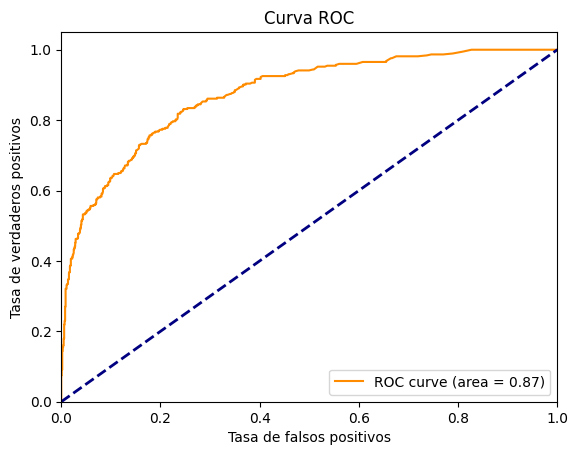


Aplicando Submuestreo (Downsampling)...

Evaluando Bosque Aleatorio con downsampling...


C:\Users\jpizz\AppData\Local\Temp\ipykernel_6888\2510307302.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  resultados = pd.concat([resultados, pd.DataFrame({'Modelo': [nombre_modelo], 'Resampleo': ['Upsampling'], 'AUC-ROC': [auc_roc_up], 'Exactitud': [accuracy_up], 'F1 Score': [f1_up]})], ignore_index=True)


Mejor modelo con downsampling: RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)
Mejores hiperparámetros con downsampling: {'max_depth': 10, 'n_estimators': 200}

Modelo: RandomForestClassifier
Matriz de confusión:
 [[617 418]
 [ 39 335]]
AUC-ROC: 0.8663
Exactitud: 0.6757
F1 Score: 0.5945


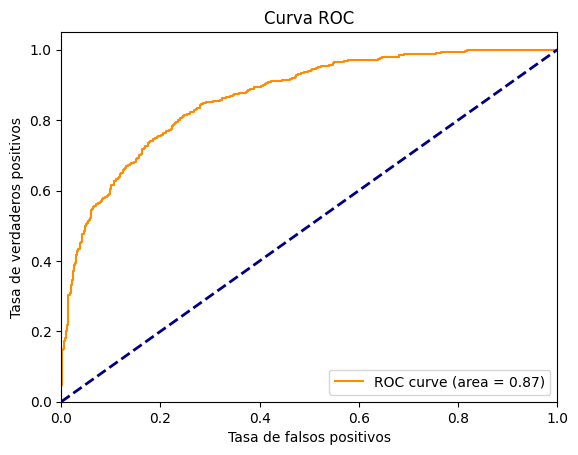



========== Modelo: LightGBM ==========

Aplicando Sobremuestreo (Upsampling)...

Evaluando LightGBM con upsampling...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2990, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5749, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.520090 -> initscore=0.080405
[LightGBM] [Info] Start training from score 0.080405


c:\Tripleten\Proyectos\interconect_churn_analysis\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Tripleten\Proyectos\interconect_churn_analysis\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2990, number of negative: 2759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 626
[LightGBM] [Info] Number of data points in the train set: 5749, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.520090 -> initscore=0.080405
[LightGBM] [Info] Start training from score 0.080405
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 2990, number of negative: 2760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

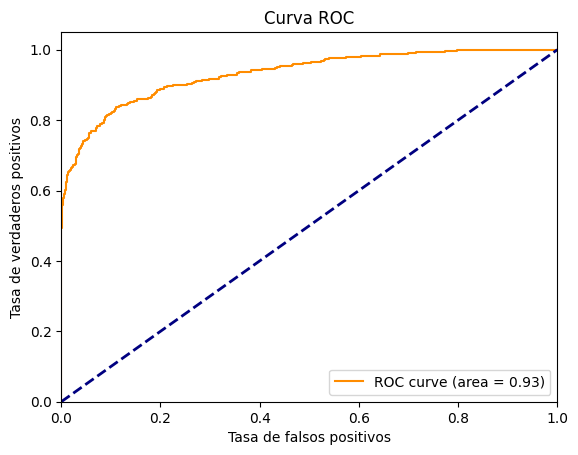


Aplicando Submuestreo (Downsampling)...

Evaluando LightGBM con downsampling...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 996, number of negative: 552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 1548, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.643411 -> initscore=0.590199
[LightGBM] [Info] Start training from score 0.590199
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 997, number of negative: 552
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `fo

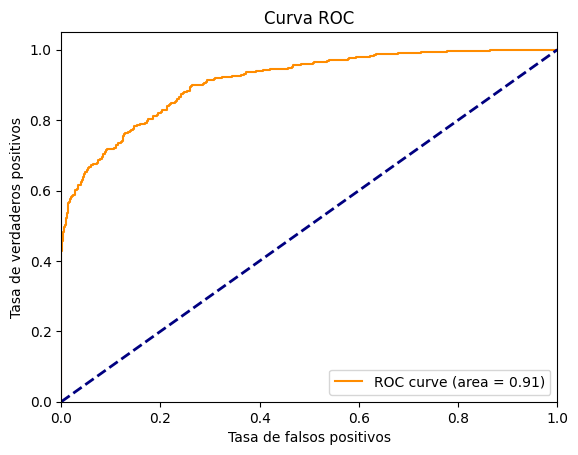



========== Modelo: XGBoost ==========

Aplicando Sobremuestreo (Upsampling)...

Evaluando XGBoost con upsampling...
Mejor modelo con upsampling: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)
Mejores hiperparámetros con upsampling: {'learning_rate': 0.1, 'n_estimators': 200}

Modelo: X

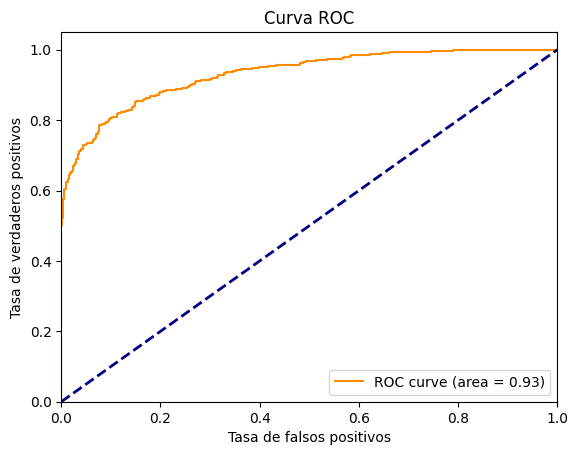


Aplicando Submuestreo (Downsampling)...

Evaluando XGBoost con downsampling...
Mejor modelo con downsampling: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)
Mejores hiperparámetros con downsampling: {'learning_rate': 0.1, 'n_estimators': 100}

Modelo: XGBClassifier
Matriz de confusión:


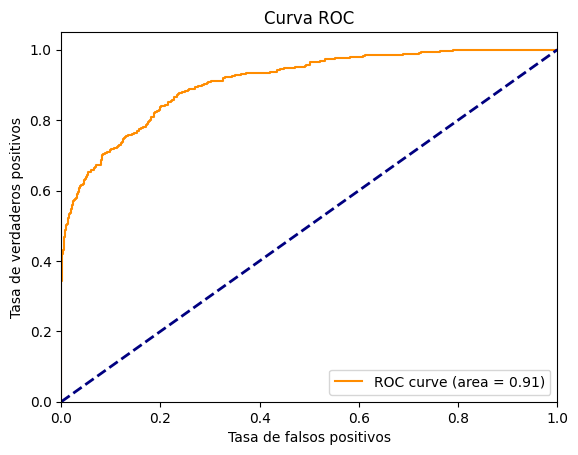


Comparación de resultados:

             Modelo     Resampleo   AUC-ROC  Exactitud  F1 Score
0  Bosque Aleatorio    Upsampling  0.874027   0.815472  0.660574
1  Bosque Aleatorio  Downsampling  0.866279   0.675656  0.594499
2          LightGBM    Upsampling  0.931822   0.882896  0.784876
3          LightGBM  Downsampling  0.910184   0.778566  0.682927
4           XGBoost    Upsampling  0.930732   0.868701  0.765526
5           XGBoost  Downsampling  0.907843   0.755855  0.664062
             Modelo     Resampleo   AUC-ROC  Exactitud  F1 Score
0  Bosque Aleatorio    Upsampling  0.874027   0.815472  0.660574
1  Bosque Aleatorio  Downsampling  0.866279   0.675656  0.594499
2          LightGBM    Upsampling  0.931822   0.882896  0.784876
3          LightGBM  Downsampling  0.910184   0.778566  0.682927
4           XGBoost    Upsampling  0.930732   0.868701  0.765526
5           XGBoost  Downsampling  0.907843   0.755855  0.664062


In [46]:
# Evaluar los modelos con ambos resampleos (upsample y downsample)
resultados = evaluar_modelos_con_ambos_resampleos(features_train_scaled, target_train, features_valid_scaled, target_valid)

# Mostrar resultados
print(resultados)

### Interpretación de los resultados

1. Bosque Aleatorio:

- Upsampling: AUC-ROC de 0.87, Exactitud de 81.55%, y F1 Score de 0.66.
- Downsampling: AUC-ROC de 0.86, Exactitud más baja de 67.56%, y F1 Score de 0.59.

2. LightGBM:

- Upsampling: AUC-ROC de 0.93, Exactitud de 88.29%, y F1 Score de 0.78.
- Downsampling: AUC-ROC de 0.91, Exactitud de 77.85%, y F1 Score de 0.68.

3. XGBoost:

- Upsampling: AUC-ROC de 0.93, Exactitud de 86.87%, y F1 Score de 0.77.
- Downsampling: AUC-ROC de 0.91, Exactitud de 75.59%, y F1 Score de 0.66.

## Conclusión:

- LightGBM con upsampling tiene el mejor desempeño en términos de AUC-ROC (0.93), Exactitud (88.29%), y F1 Score (0.78).
- En general, upsampling parece mejorar el rendimiento para todos los modelos en comparación con downsampling en términos de AUC-ROC, Exactitud, y F1 Score.
- XGBoost también ofrece un buen rendimiento, especialmente con upsampling, pero queda un poco por debajo de LightGBM.

El análisis ha mostrado que los clientes con contratos de mes a mes y aquellos que utilizan cheques electrónicos como método de pago tienen mayores tasas de cancelación, especialmente durante los primeros meses de servicio. En contraste, los contratos de uno o dos años y los pagos automáticos están asociados con una mayor retención.

Recomendación
Para reducir la tasa de cancelación, se sugiere incentivar los contratos a largo plazo, fomentar el uso de pagos automáticos y mejorar la experiencia de los clientes durante los primeros meses con programas de fidelización. Además, sería útil implementar estrategias proactivas para identificar clientes en riesgo y ofrecerles promociones antes de que cancelen. Estas medidas ayudarían a mejorar la retención y estabilidad de la base de clientes.